# Measuring efficiency from multiple datasets

## Importing

In [3]:
import pandas as pd

In [4]:
from rpy2.robjects import pandas2ri
from rpy2.robjects import Formula


### Importing `ECoL`

In [5]:
# import rpy2's package module
from rpy2.robjects import packages as rpackages

# Import Ecol
ecol = rpackages.importr('ECoL')

## Setting up our targets

In [6]:
C2_TARGET = 0
L2_TARGET = 0.01160101
N1_TARGET = 0.10666666666666667
F2_TARGET = 0.006381766381766379

In [7]:
filename_csv = 'Exasens_filtered.csv'
target_df = pd.read_csv(filename_csv)
TARGET_COLUMN = 'Diagnosis'


In [8]:
pandas2ri.activate()

# target_df = target_df.drop("Unnamed: 0", axis=1)
fml = Formula(TARGET_COLUMN + " ~ .")

target_df = pandas2ri.py2rpy(target_df)

c2Vector = ecol.balance_formula(
    fml, target_df, measures="C2", summary="return")
l2Vector = ecol.linearity_formula(
    fml, target_df, measures="L2", summary="return")
n1Vector = ecol.neighborhood_formula(fml, target_df, measures="N1")
f2Vector = ecol.overlapping_formula(fml, target_df, measures="F2")

C2_TARGET = c2Vector.rx(1)[0][0]
L2_TARGET = l2Vector.rx(1)[0][0]
N1_TARGET = n1Vector.rx(1)[0][0]
F2_TARGET = f2Vector.rx(1)[0][0]


In [9]:
print(f"C2 = {C2_TARGET}")
print(f"L2 = {L2_TARGET}")
print(f"N1 = {N1_TARGET}")
print(f"F2 = {F2_TARGET}")

C2 = 0.1428571428571428
L2 = 0.08261003008566184
N1 = 0.49
F2 = 0.00786055493695772


## Reading our datasets

In [10]:
QUANTITIES_OF_DATASETS = 6

### Reading each dataset

In [11]:
v_df = []

for i in range(0, QUANTITIES_OF_DATASETS):
    filename = str(i) + "-NGEN=20000-C2-L2-N1-F2"
    v_df.append(pd.read_csv(filename + ".csv"))
    v_df[i] = v_df[i].drop("Unnamed: 0", axis=1)


### Conversion to a R DataFrame

In [12]:
pandas2ri.activate()

# Convert to r_df
r_df = []
[r_df.append(pandas2ri.py2rpy(v_df[i]))
 for i in range(0, QUANTITIES_OF_DATASETS)]

fml = Formula('label ~ .')


## Measuring Complexity

### C2 - L2 - N1 - F2 Measures

In [32]:
data = []

for df in r_df:
    c2Vector = ecol.balance_formula(fml, df, measures="C2", summary="return")
    l2Vector = ecol.linearity_formula(fml, df, measures="L2", summary="return")
    n1Vector = ecol.neighborhood_formula(fml, df, measures="N1")
    f2Vector = ecol.overlapping_formula(fml, df, measures="F2")

    data.append([
        c2Vector.rx(1)[0][0],
        l2Vector.rx(1)[0][0],
        n1Vector.rx(1)[0][0],
        f2Vector.rx(1)[0][0]
    ])


In [33]:
results = pd.DataFrame(data, columns=['C2','L2','N1','F2'])

In [37]:
results.head()

,C2,L2,N1,F2
0,0.142934,0.082588,0.485,0.012724
1,0.148539,0.082610,0.505,0.016358
2,0.147341,0.082592,0.515,0.014419
3,0.141521,0.082399,0.505,0.010593
4,0.148062,0.081411,0.525,0.008252


## Taking a look at our results

Text(0, 0.5, 'Complexity Values')

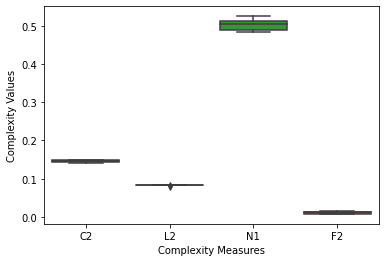

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.boxplot(data=results)
plt.xlabel("Complexity Measures")
plt.ylabel("Complexity Values")

In [17]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y=c2, name="C2", boxpoints="all"))
fig.add_trace(go.Scatter(x=["C2"], y=[C2_TARGET], mode="markers", marker_symbol=41, marker_line_color="blue",
                         marker_line_width=2, marker_size=30, name="C2 Target"))
fig.add_trace(go.Box(y=l2, name="L2", boxpoints="all"))
fig.add_trace(go.Scatter(x=["L2"], y=[L2_TARGET], mode="markers", marker_symbol=41, marker_line_color="blue",
                         marker_line_width=2, marker_size=30, name="L2 Target"))
fig.add_trace(go.Box(y=n1, name="N1", boxpoints="all"))
fig.add_trace(go.Scatter(x=["N1"], y=[N1_TARGET], mode="markers", marker_symbol=41, marker_line_color="blue",
                         marker_line_width=2, marker_size=30, name="N1 Target"))
fig.add_trace(go.Box(y=f2, name="F2", boxpoints="all"))
fig.add_trace(go.Scatter(x=["F2"], y=[F2_TARGET], mode="markers", marker_symbol=41, marker_line_color="blue",
                         marker_line_width=2, marker_size=30, name="F2 Target"))


fig.update_layout(
    title="Sythentic Dataset Generation efficiency for 20000 generations ("
    + filename_csv + ')',
    xaxis_title="Complexity Measure",
    yaxis_title="Complexity Value",
    legend_title="Targets",
    width=1040,
    height=650
)

fig.show()
